In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from DDBSCAN import Raster_DBSCAN
import matplotlib.colors as mcolors
import cv2
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

In [148]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
lane_unit = 200
time_span = 100
hidden_size = 256
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0913_5res_lanechange_signal\models\train_3"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_20.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[3,13],eps = 1,min_samples=3)

In [167]:
def get_trajs_from_LSTM_out(time_space_diagram,conf_thred = 0.35,time_span = 100, lane_unit = 200):
    pred_trajectories = time_space_diagram > conf_thred
    Labels = db.fit_predict(pred_trajectories, pred_trajectories)
    num_lane_units, time_span = time_space_diagram.shape
    # Create a dictionary to store the (x,t) profiles for each label
    trajectories_output = defaultdict(list)
    for t in range(time_span):
        Labels_t = Labels[:,t]
        unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
        center_locations = xs + counts / 2
        if unique_id[0] == -1:
            unique_id = unique_id[1:]
            center_locations = center_locations[1:]
        for i, label in enumerate(unique_id):
            trajectories_output[label].append((t,center_locations[i]))
    # calculate speed for each trajectory
    # speed_output = []
    for key in trajectories_output.keys():
        traj = trajectories_output[key]
        t, x = zip(*traj)
        t = np.array(t)
        x = np.array(x)
        speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
        speed = np.concatenate([speed,[speed[-1]]])
        # add to the dictionary
        trajectories_output[key] = np.c_[t,x,speed]
        # speed_output.append(speed)

    return trajectories_output

In [221]:
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v4i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v4i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
time_span = 100
lane_unit_num = 200
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
for i in range(len(time_space_diagram_list)):
    time_space_diagram_name = time_space_diagram_list[i]
    trajectory = trajectory_list[i]
    time_space_diagram = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    # read labels in txt file in keypoint format for yolov8 and extract the keypoint coordinates
    lines = []
    with open(os.path.join(traj_dir,trajectory),'r') as f:
        for line in f:
            line = line.strip().split()
            line = [float(i) for i in line]
            lines.append(line)
    lines = np.array(lines)
    trajs_label = []
    # from index 8 of each row is the keypoint coordinates: something, x,y , something, x,y ...
    for line in lines:
        coords = []
        for i in range(5,len(line),3):
            coords.append((line[i],line[i+1]))
        coords = np.array(coords)
        coords[:,0] *= time_space_diagram.shape[1]
        coords[:,1] *= time_space_diagram.shape[0]
        traj = coords[coords[:,0].argsort()]
        trajs_label.append(traj)
    
    
    time_space_diagram = time_space_diagram > 100
    time_space_diagram = time_space_diagram.astype(np.uint8)
    original_shape = time_space_diagram.shape
    padding = np.zeros((lane_unit_num - time_space_diagram.shape[0], time_space_diagram.shape[1]))
    test_diagram = np.concatenate((time_space_diagram,padding), axis=0)
    with torch.no_grad():
        input_snippet = torch.from_numpy(test_diagram).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = 0.35,time_span = 100, lane_unit = 200)
    break

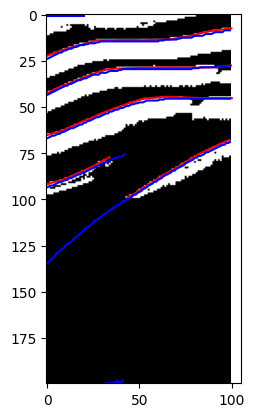

In [222]:
plt.imshow(test_diagram,cmap='gray')
for traj in trajs_label:
    plt.plot(traj[:,0],traj[:,1],'r')
for traj in trajs_pred.values():
    t, x, s = zip(*traj)
    plt.plot(t,x,'b')
plt.show()

In [270]:
t_pred >= t_label[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

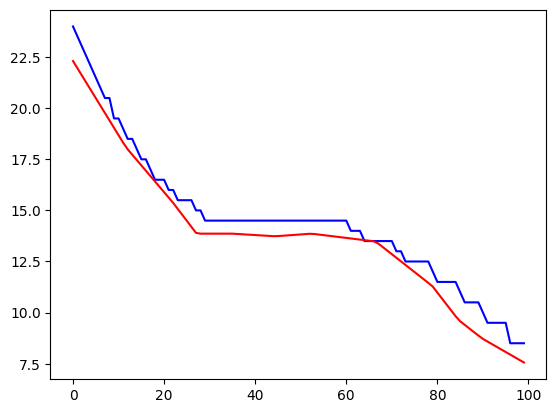

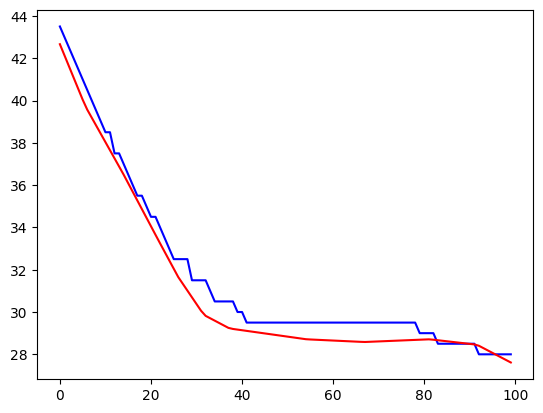

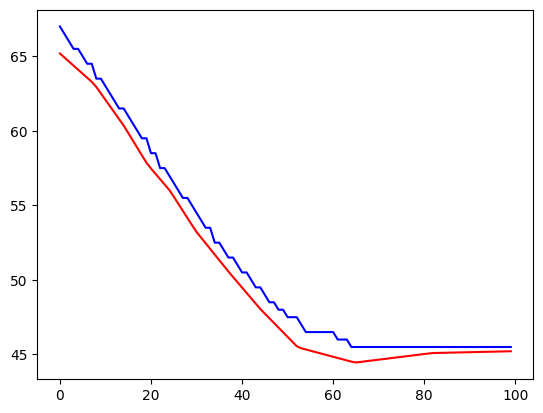

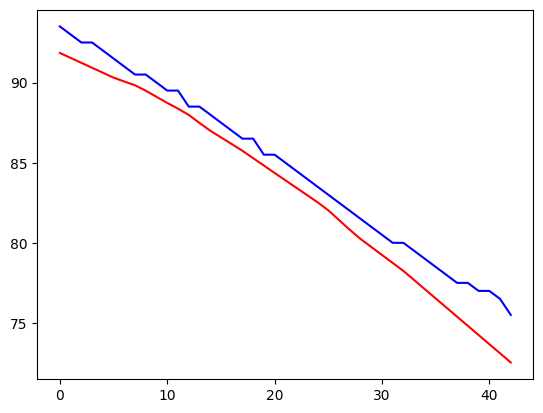

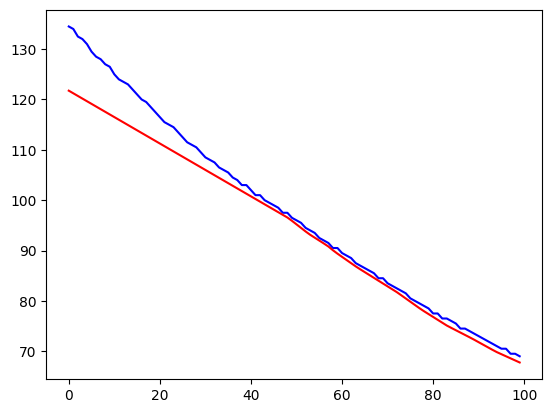

In [276]:
# evaluate 
speed_eva_window = 5

speed_errors = []
location_errors = []
Traj_IoU = []
for i, traj_label in enumerate(trajs_label):
    for j, traj_pred in enumerate(trajs_pred.values()):
        # Extract time and x values
        t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
        t_label, x_label = traj_label[:, 0], traj_label[:, 1]

        # Interpolate label trajectory to match pred trajectory time points
        interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
        x_label_interp = interp_func(t_pred)
        # get the overlapping time span
        t_label_max,t_label_min = t_label[-1],t_label[0]
        t_pred_max,t_pred_min = t_pred[-1],t_pred[0]
        # if two trajectories have overlapping time span

        if t_pred_max < t_label_min or t_pred_min > t_label_max:
            continue
        overlap_start = max(t_pred_min,t_label_min)
        overlap_end = min(t_pred_max,t_label_max)
        x_label_interp_overlap = x_label_interp[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
        x_pred_overlap = x_pred[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
        # Calculate residuals
        residuals = x_pred_overlap - x_label_interp_overlap 
        location_error = np.mean(np.abs(residuals)) * 0.5 # meters
        
        if location_error < 5: # they are the same trajectory
            location_errors.append(location_error)
            # calculate Traj IoU indicating the overlapping ratio of two trajectories
            
            

            # calculate speed error
            speed_pred_curve = []
            speed_label_curve = []
            for k in range(len(residuals)-speed_eva_window):
                speed_pred = (x_pred_overlap[k+speed_eva_window] - x_pred_overlap[k])*0.5 / (speed_eva_window/10)
                speed_label = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
                speed_pred_curve.append(speed_pred)
                speed_label_curve.append(speed_label)
            speed_pred_curve = np.array(speed_pred_curve)
            speed_label_curve = np.array(speed_label_curve)
            speed_error = np.mean(np.abs(speed_pred_curve - speed_label_curve)) # m/s
            speed_errors.append(speed_error)

In [274]:
location_errors

[0.38203034279848935,
 0.333609612770622,
 0.4862387393823102,
 0.5505104308187037,
 0.4659909293396905]

In [275]:
speed_errors

[0.28493514426466326,
 0.2324994939263297,
 0.23293964712646853,
 0.28605542454100785,
 0.21301159012651652]